# **Library Installation and Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


# **Load Processed DataFrames**

In [2]:
load_path = "/content/drive/MyDrive/DS_LAB/Processed/"

filtered_user1 = pd.read_pickle(load_path + "filtered_user1.pkl")
filtered_user2 = pd.read_pickle(load_path + "filtered_user2.pkl")
combined_df   = pd.read_pickle(load_path + "combined_df.pkl")

print("DataFrames loaded")
print(f"User1 shape: {filtered_user1.shape}")
print(f"User2 shape: {filtered_user2.shape}")
print(f"Combined shape: {combined_df.shape}")

DataFrames loaded
User1 shape: (645, 15)
User2 shape: (645, 15)
Combined shape: (1290, 15)


# **EDA (Exploratory Data Analysis)**

In [3]:
for df, name in zip([filtered_user1, filtered_user2, combined_df],
                    ["User 1", "User 2", "Combined"]):
    print(f"\n------- {name} -------")
    print()
    print(df.describe())
    print()
    print(df.info())
    print()


------- User 1 -------

       user_id                       datetime         wpm      rawWpm  \
count    645.0                            645  645.000000  645.000000   
mean       1.0  2025-04-28 04:45:45.173674240   70.452295   72.979070   
min        1.0            2024-11-10 08:36:37   18.800000   25.200000   
25%        1.0            2024-11-20 17:13:37   65.200000   67.600000   
50%        1.0            2025-06-04 10:25:32   71.190000   73.590000   
75%        1.0            2025-08-03 12:01:29   75.600000   78.000000   
max        1.0     2025-08-14 06:22:23.020000   91.190000   91.600000   
std        0.0                            NaN    7.832761    7.347307   

              acc  consistency  restartCount  testDuration  afkDuration  \
count  645.000000   645.000000    645.000000    645.000000   645.000000   
mean    96.119814    71.582388      0.737984     30.003287     0.062016   
min     75.000000    26.570000      0.000000     30.000000     0.000000   
25%     94.710000

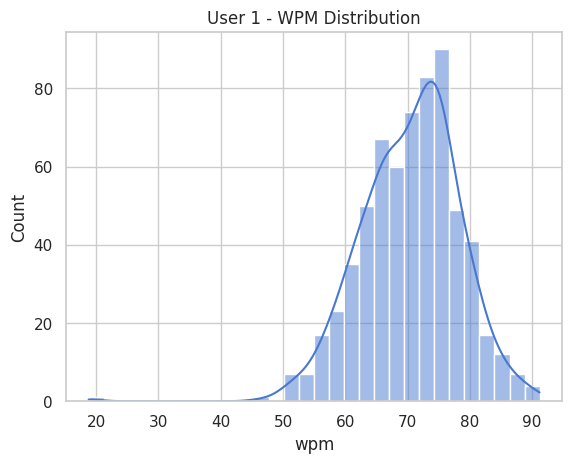

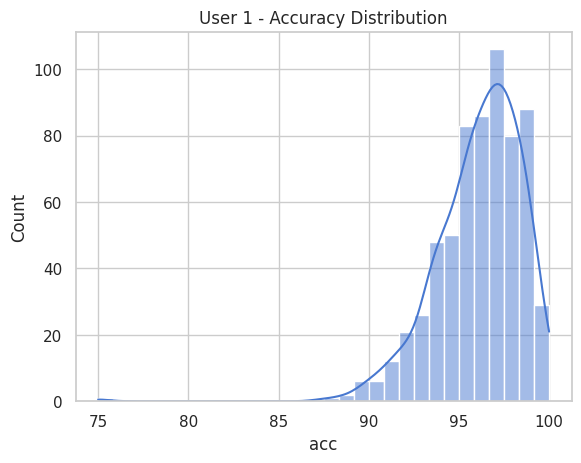

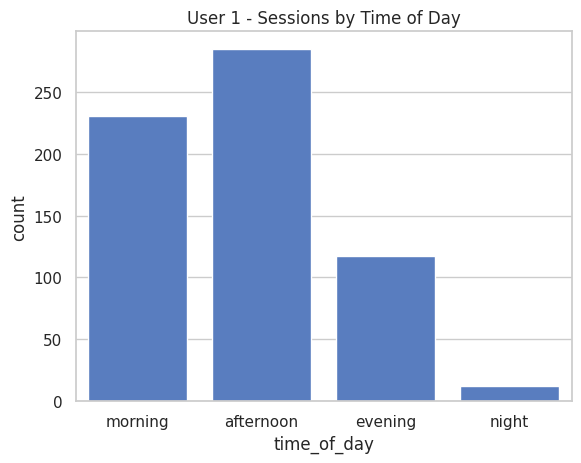

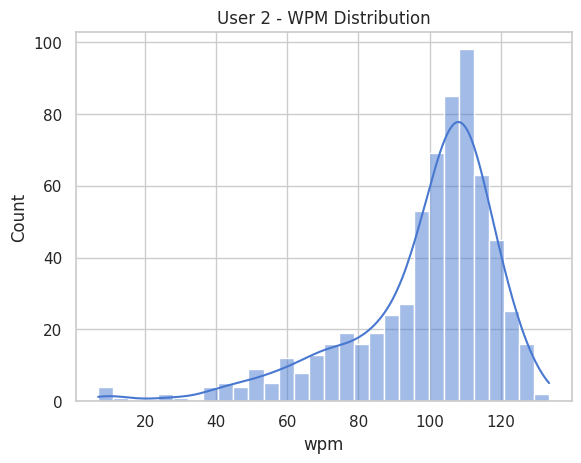

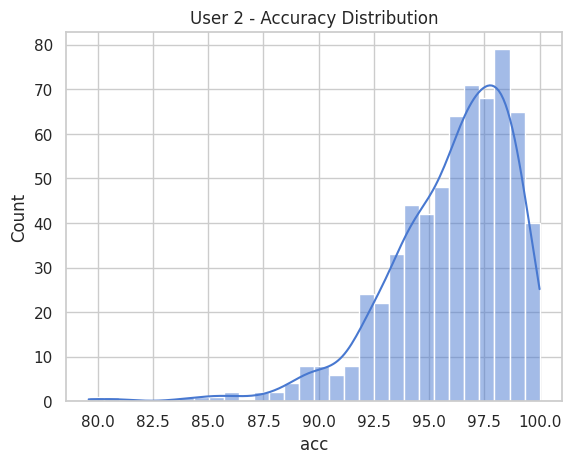

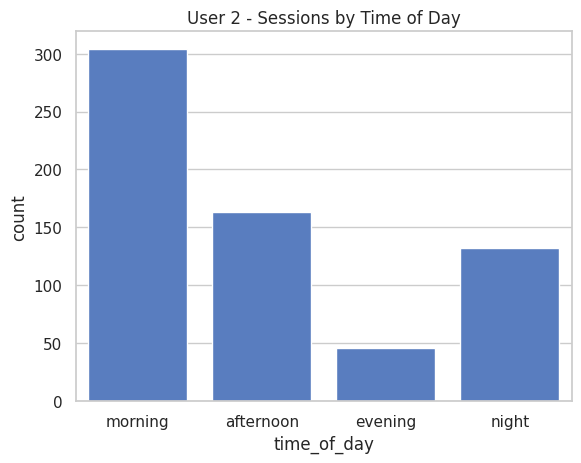

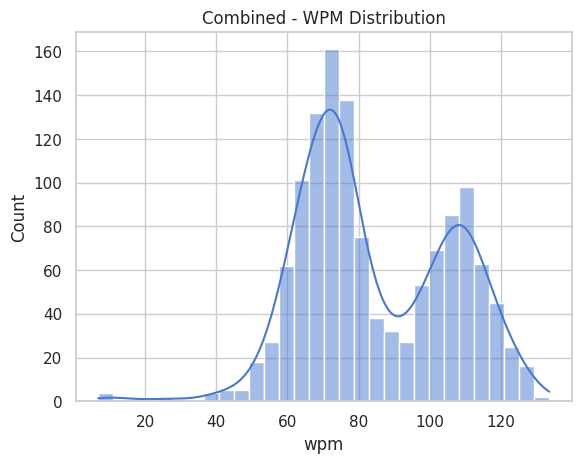

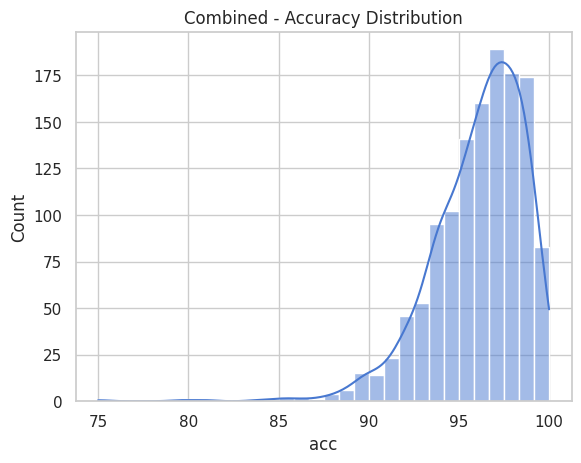

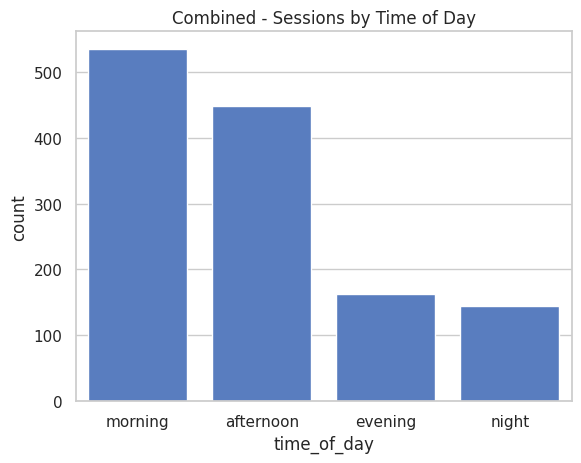

In [4]:
sns.set(style="whitegrid", palette="muted")
for df, name in zip([filtered_user1, filtered_user2, combined_df],
                    ["User 1", "User 2", "Combined"]):

    sns.histplot(df['wpm'], kde=True, bins=30)
    plt.title(f"{name} - WPM Distribution")
    plt.show()
    print()

    sns.histplot(df['acc'], kde=True, bins=30)
    plt.title(f"{name} - Accuracy Distribution")
    plt.show()
    print()

    sns.countplot(data=df, x="time_of_day", order=['morning','afternoon','evening','night'])
    plt.title(f"{name} - Sessions by Time of Day")
    plt.show()
    print()

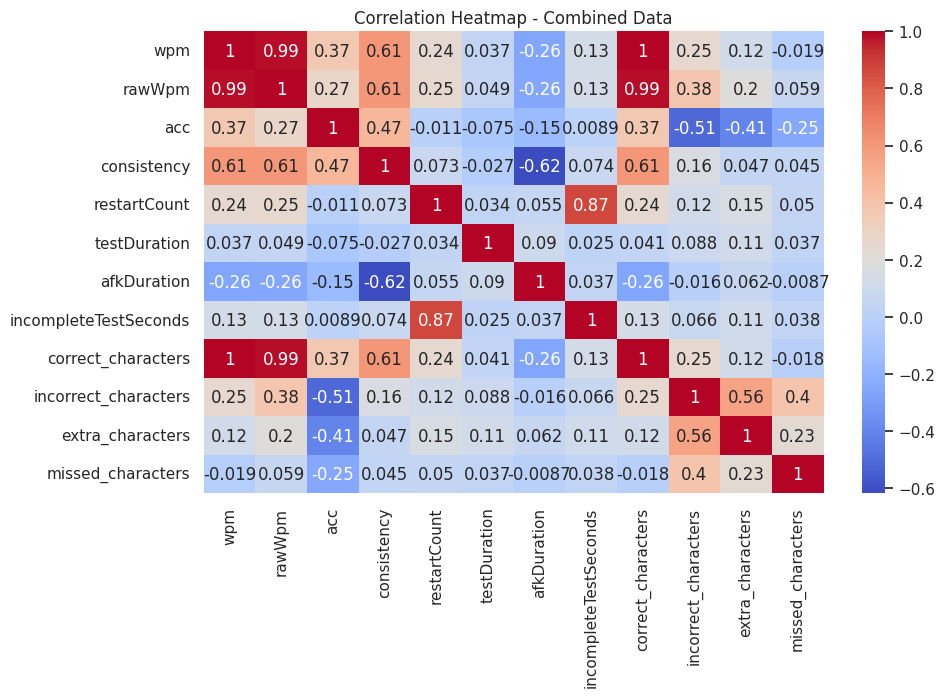

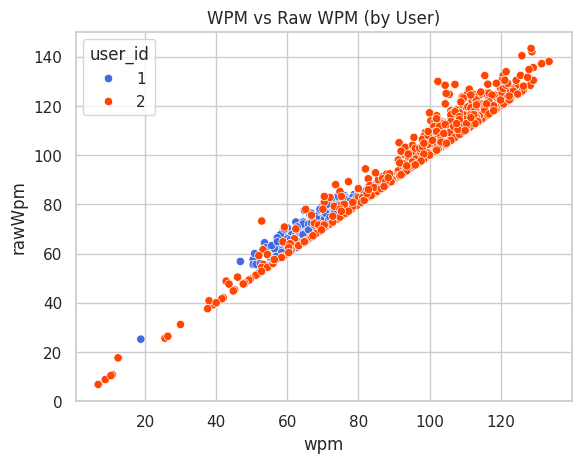

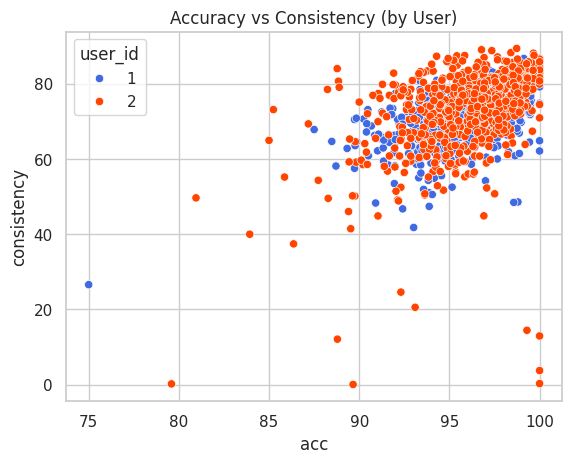

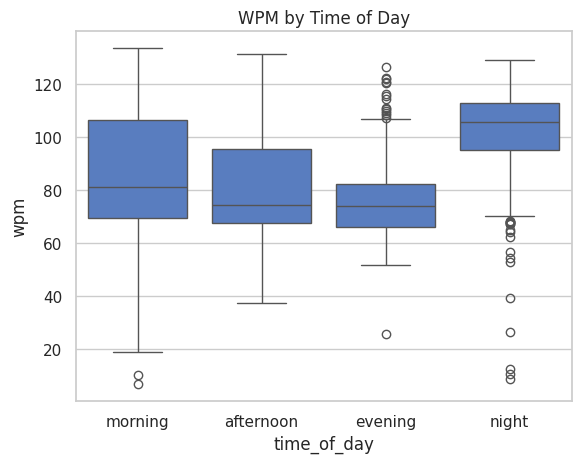

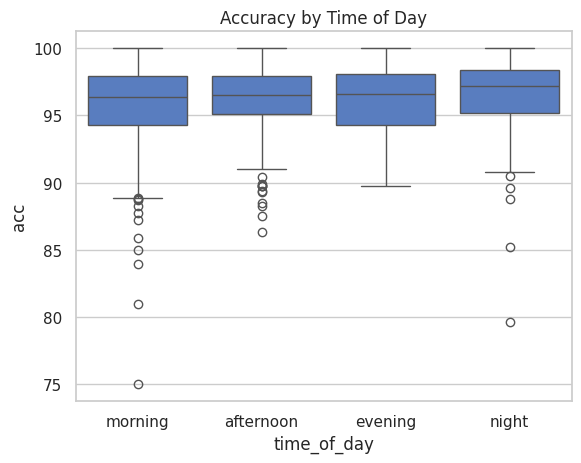

In [5]:
sns.set(style="whitegrid", palette="muted")
user_palette = {1: "royalblue", 2: "orangered"}
numeric_cols = ['wpm', 'rawWpm', 'acc', 'consistency',
                'restartCount', 'testDuration', 'afkDuration', 'incompleteTestSeconds',
                'correct_characters', 'incorrect_characters', 'extra_characters', 'missed_characters']

plt.figure(figsize=(10,6))
sns.heatmap(combined_df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap - Combined Data")
plt.show()
print()

sns.scatterplot(data=combined_df, x="wpm", y="rawWpm", hue="user_id", palette=user_palette)
plt.title("WPM vs Raw WPM (by User)")
plt.show()
print()

sns.scatterplot(data=combined_df, x="acc", y="consistency", hue="user_id", palette=user_palette)
plt.title("Accuracy vs Consistency (by User)")
plt.show()
print()

sns.boxplot(data=combined_df, x="time_of_day", y="wpm", order=['morning','afternoon','evening','night'])
plt.title("WPM by Time of Day")
plt.show()
print()

sns.boxplot(data=combined_df, x="time_of_day", y="acc", order=['morning','afternoon','evening','night'])
plt.title("Accuracy by Time of Day")
plt.show()
print()

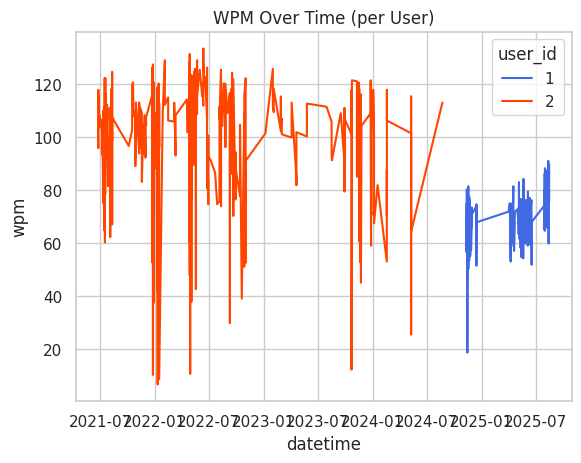

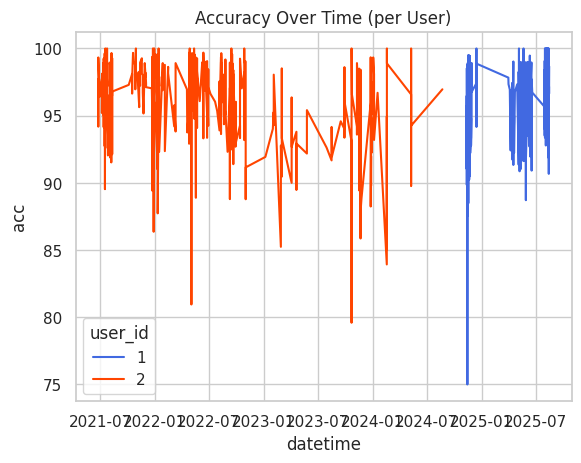

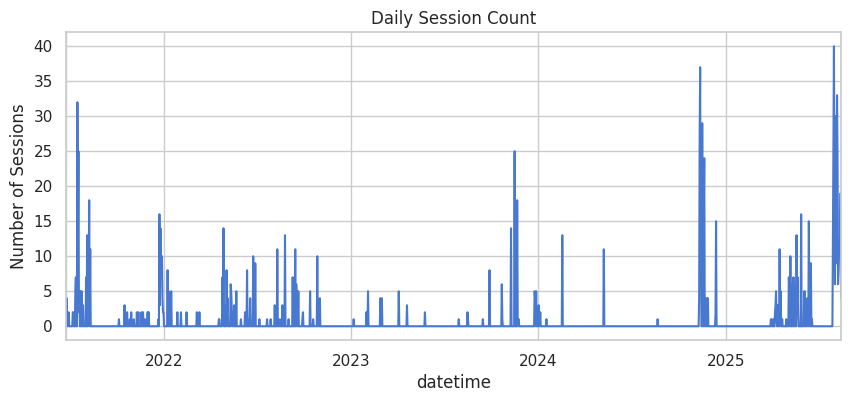

In [6]:
sns.set(style="whitegrid", palette="muted")
sns.lineplot(data=combined_df, x="datetime", y="wpm", hue="user_id", palette=user_palette)
plt.title("WPM Over Time (per User)")
plt.show()
print()

sns.lineplot(data=combined_df, x="datetime", y="acc", hue="user_id", palette=user_palette)
plt.title("Accuracy Over Time (per User)")
plt.show()
print()

daily_counts = combined_df.set_index("datetime").resample("D")["wpm"].count()
daily_counts.plot(figsize=(10,4))
plt.title("Daily Session Count")
plt.ylabel("Number of Sessions")
plt.show()
print()

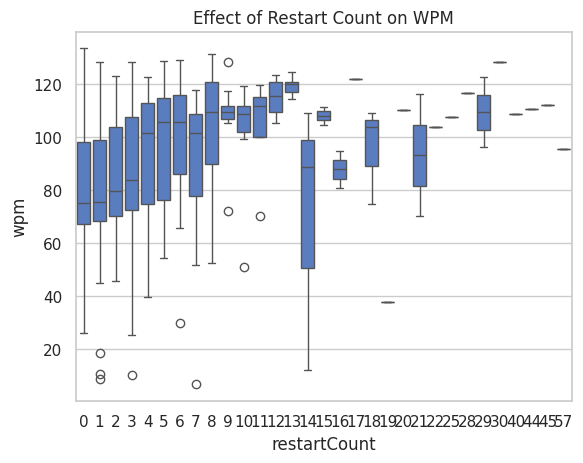

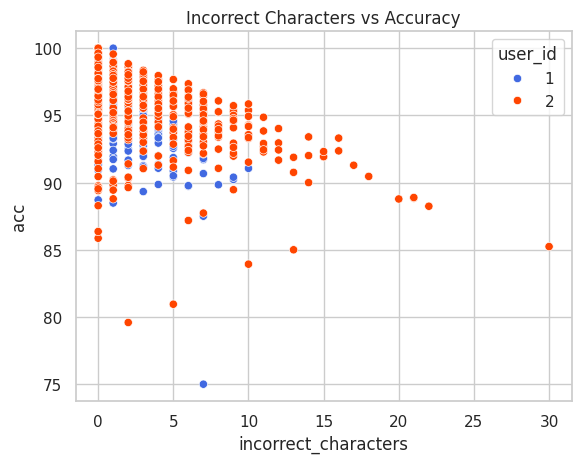

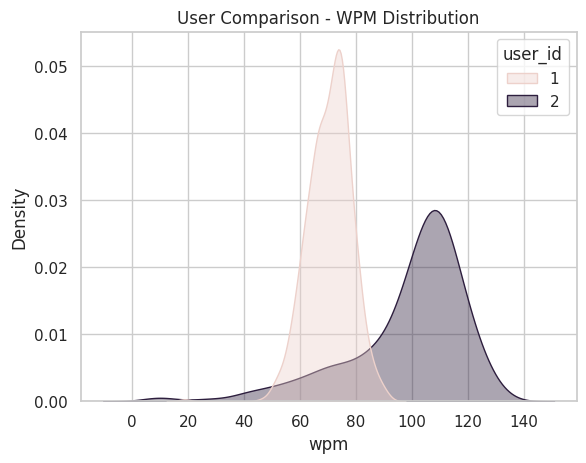

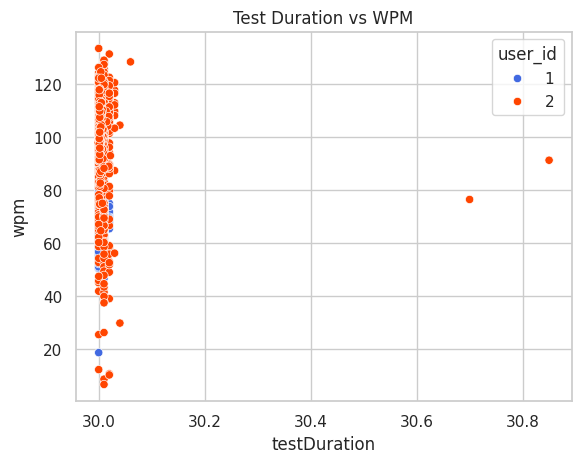

In [7]:
sns.set(style="whitegrid", palette="muted")
sns.boxplot(data=combined_df, x="restartCount", y="wpm")
plt.title("Effect of Restart Count on WPM")
plt.show()
print()

sns.scatterplot(data=combined_df, x="incorrect_characters", y="acc", hue="user_id", palette=user_palette)
plt.title("Incorrect Characters vs Accuracy")
plt.show()
print()

sns.kdeplot(data=combined_df, x="wpm", hue="user_id", fill=True, common_norm=False, alpha=0.4)
plt.title("User Comparison - WPM Distribution")
plt.show()
print()

sns.scatterplot(data=combined_df, x="testDuration", y="wpm", hue="user_id", palette=user_palette)
plt.title("Test Duration vs WPM")
plt.show()
print()

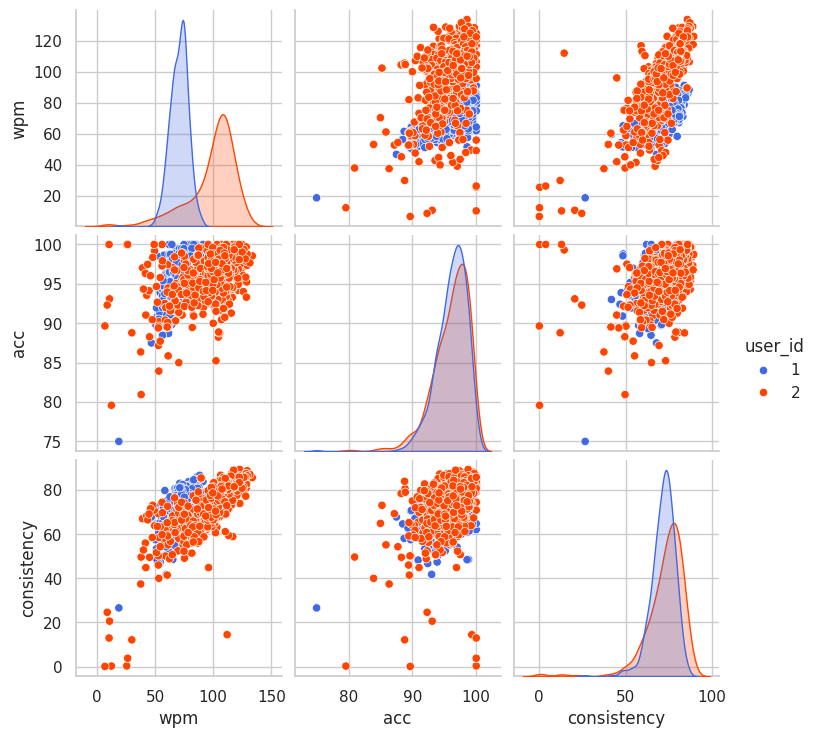

In [8]:
sns.pairplot(combined_df, vars=["wpm","acc","consistency"], hue="user_id", palette=user_palette)
plt.show()

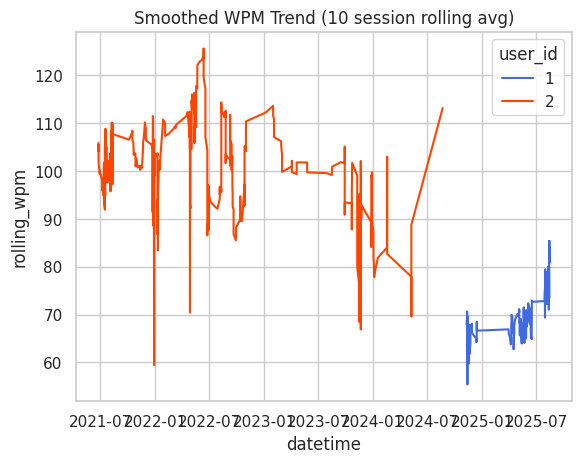

In [9]:
combined_df['rolling_wpm'] = combined_df.groupby("user_id")['wpm'].transform(lambda x: x.rolling(10, min_periods=1).mean())
sns.lineplot(data=combined_df, x="datetime", y="rolling_wpm", hue="user_id", palette=user_palette)
plt.title("Smoothed WPM Trend (10 session rolling avg)")
plt.show()

# **Clustering - (KMeans + GMM)**

In [10]:
dfc = combined_df.copy()
dfc = pd.get_dummies(dfc, columns=['time_of_day'], drop_first=True)

perf_only = [
    'wpm', 'rawWpm', 'acc', 'consistency',
    'correct_characters', 'incorrect_characters', 'extra_characters', 'missed_characters'
]

perf_plus_behavior = perf_only + [
    'restartCount', 'testDuration', 'afkDuration', 'incompleteTestSeconds',
] + [c for c in dfc.columns if c.startswith('time_of_day_')]

FEATURES = perf_plus_behavior
X = dfc[FEATURES].astype(float)
meta_cols = ['user_id', 'datetime']
meta = dfc[meta_cols].reset_index(drop=True)

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=None, random_state=42)
X_pcs = pca.fit_transform(X_scaled)

explained = np.cumsum(pca.explained_variance_ratio_)
var90 = np.argmax(explained >= 0.90) + 1
print(f"PCA components to explain ≥90% variance: {var90}")
print(f"Explained variance by PC1, PC2: {pca.explained_variance_ratio_[0]:.3f}, {pca.explained_variance_ratio_[1]:.3f}")

pc2 = X_pcs[:, :2]
pc_df = pd.DataFrame(pc2, columns=['PC1','PC2'])
viz_base = pd.concat([meta.reset_index(drop=True), pc_df], axis=1)

PCA components to explain ≥90% variance: 9
Explained variance by PC1, PC2: 0.270, 0.158


In [12]:
inertias = []
sils = []
ks = range(2, 9)

for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))

print("k values:", list(ks))
print("Inertia (elbow):", [round(v,2) for v in inertias])
print("Silhouette:", [round(v,3) for v in sils])

best_k = ks[int(np.argmax(sils))]
print(f"Chosen k (by silhouette): {best_k}")

k values: [2, 3, 4, 5, 6, 7, 8]
Inertia (elbow): [15669.29, 14197.15, 12818.74, 11596.61, 10514.61, 9519.4, 8413.48]
Silhouette: [np.float64(0.251), np.float64(0.261), np.float64(0.233), np.float64(0.25), np.float64(0.254), np.float64(0.262), np.float64(0.271)]
Chosen k (by silhouette): 8


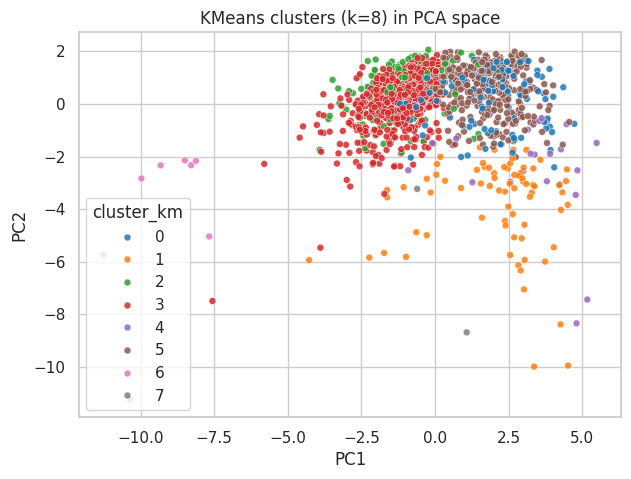

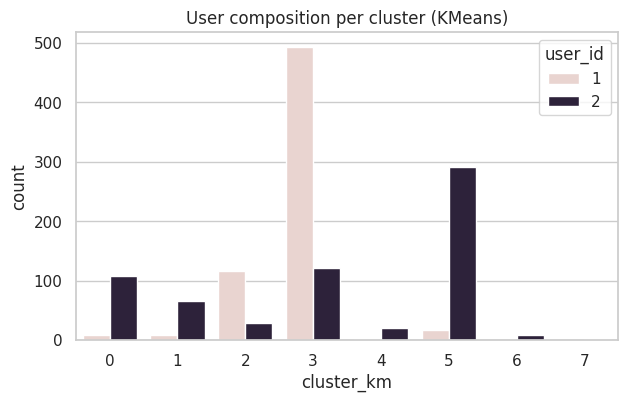

In [17]:
best_km = KMeans(n_clusters=best_k, n_init=20, random_state=42)
km_labels = best_km.fit_predict(X_scaled)
combined_km = combined_df.copy()
combined_km['cluster_km'] = km_labels

plt.figure(figsize=(7,5))
sns.scatterplot(data=pd.concat([viz_base, pd.Series(km_labels, name='cluster_km')], axis=1),
                x='PC1', y='PC2', hue='cluster_km', palette='tab10', s=25, alpha=0.85)
plt.title(f'KMeans clusters (k={best_k}) in PCA space')
plt.show()
print()

plt.figure(figsize=(7,4))
sns.countplot(data=combined_km, x='cluster_km', hue='user_id')
plt.title('User composition per cluster (KMeans)')
plt.show()

Components: [2, 3, 4, 5, 6, 7, 8]
BIC: [np.float64(15763.7), np.float64(-9927.8), np.float64(-31517.7), np.float64(-28034.5), np.float64(-39458.4), np.float64(-37652.0), np.float64(-43006.0)]
Chosen components (by BIC): 8



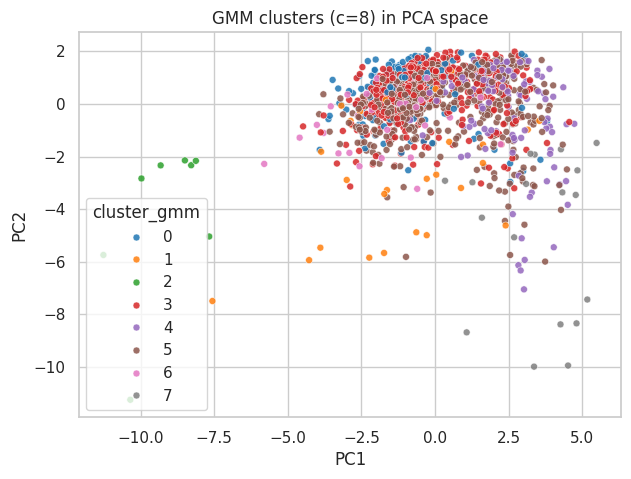

In [19]:
components = range(2, 9)
bics = []
gmms = []

for c in components:
    gmm = GaussianMixture(n_components=c, covariance_type='full', random_state=42, n_init=5)
    gmm.fit(X_scaled)
    gmms.append(gmm)
    bics.append(gmm.bic(X_scaled))

best_c = components[int(np.argmin(bics))]
best_gmm = gmms[int(np.argmin(bics))]
gmm_labels = best_gmm.predict(X_scaled)
gmm_probs = best_gmm.predict_proba(X_scaled)

print("Components:", list(components))
print("BIC:", [round(v,1) for v in bics])
print(f"Chosen components (by BIC): {best_c}")
print()

combined_gmm = pd.concat([dfc.reset_index(drop=True), meta,
                          pd.Series(gmm_labels, name='cluster_gmm')], axis=1)

plt.figure(figsize=(7,5))
sns.scatterplot(data=pd.concat([viz_base, pd.Series(gmm_labels, name='cluster_gmm')], axis=1),
                x='PC1', y='PC2', hue='cluster_gmm', palette='tab10', s=25, alpha=0.85)
plt.title(f'GMM clusters (c={best_c}) in PCA space')
plt.show()

KMeans cluster sizes:
 cluster_km
0    116
1     74
2    145
3    615
4     22
5    308
6      8
7      2
Name: count, dtype: int64

KMeans user mix (proportion):
 user_id            1         2
cluster_km                    
0           0.068966  0.931034
1           0.108108  0.891892
2           0.806897  0.193103
3           0.803252  0.196748
4           0.045455  0.954545
5           0.055195  0.944805
6           0.000000  1.000000
7           0.000000  1.000000

KMeans feature means:
                wpm  rawWpm    acc  consistency  correct_characters  \
cluster_km                                                           
0           104.06  106.90  97.07        75.18              260.22   
1           101.52  112.31  92.44        75.79              253.89   
2            73.67   75.88  96.16        70.34              184.19   
3            70.19   72.67  95.66        69.71              175.50   
4           104.66  107.99  96.84        75.61              261.73   
5           

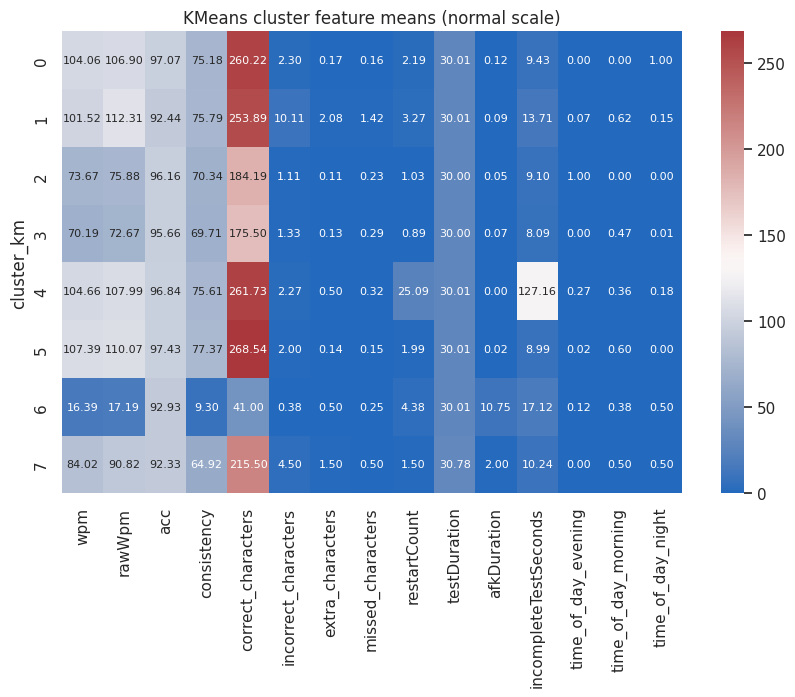

In [25]:
def profile_clusters(df_with_labels, label_col, features):
    size = df_with_labels.groupby(label_col).size().rename('count')
    user_mix = (df_with_labels
                .groupby([label_col, 'user_id']).size()
                .unstack(fill_value=0))
    user_mix = (user_mix.T / user_mix.sum(axis=1)).T
    feat_means = df_with_labels.groupby(label_col)[features].mean().round(2)
    return size, user_mix, feat_means

km_size, km_user_mix, km_means = profile_clusters(
    pd.concat([dfc.reset_index(drop=True), pd.Series(km_labels, name='cluster_km')], axis=1),
    'cluster_km', FEATURES
)

print("KMeans cluster sizes:\n", km_size)
print("\nKMeans user mix (proportion):\n", km_user_mix)
print("\nKMeans feature means:\n", km_means)
print()

plt.figure(figsize=(10,6))
sns.heatmap(km_means, annot=True, fmt=".2f", cmap="vlag", annot_kws={"size":8})
plt.title("KMeans cluster feature means (normal scale)")
plt.show()

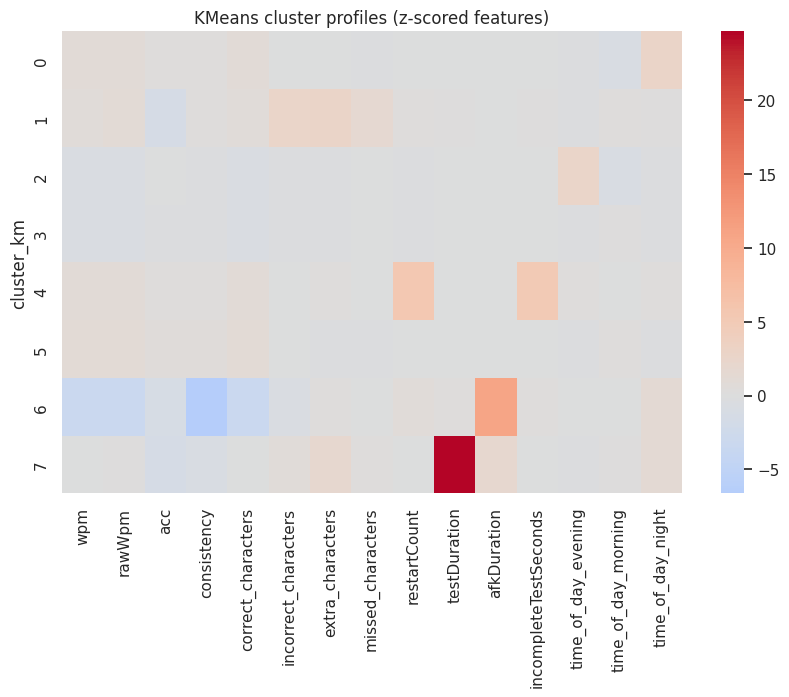

In [22]:
X_z = (X - X.mean()) / X.std(ddof=0)
z_means = pd.DataFrame(X_z).assign(cluster_km=km_labels).groupby('cluster_km').mean()

plt.figure(figsize=(10,6))
sns.heatmap(z_means, center=0, cmap="coolwarm", annot=False)
plt.title("KMeans cluster profiles (z-scored features)")
plt.show()

KMeans time-of-day composition (mean of one-hot):
             time_of_day_evening  time_of_day_morning  time_of_day_night
cluster_km                                                             
0                          0.00                 0.00               1.00
1                          0.07                 0.62               0.15
2                          1.00                 0.00               0.00
3                          0.00                 0.47               0.01
4                          0.27                 0.36               0.18
5                          0.02                 0.60               0.00
6                          0.12                 0.38               0.50
7                          0.00                 0.50               0.50

KMeans transition matrix (probabilities):
 next         0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0
cluster_km                                                
0           0.66  0.06  0.01  0.08  0.05  0.12  0.02  0.00
1       

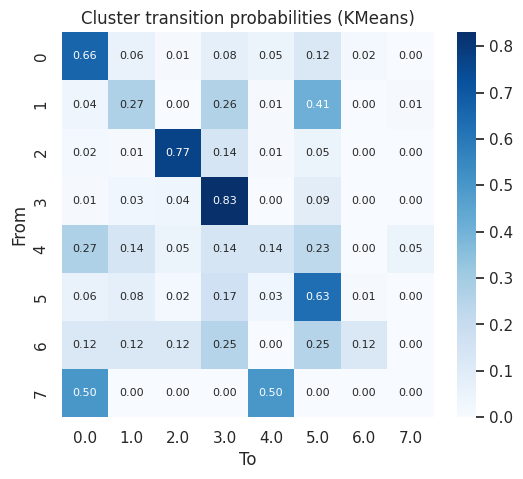

In [26]:
tod_cols = [c for c in dfc.columns if c.startswith('time_of_day_')]
km_tod_means = pd.concat([pd.DataFrame(X[ tod_cols ]),
                          pd.Series(km_labels, name='cluster_km')], axis=1) \
                 .groupby('cluster_km').mean().round(2)
print("KMeans time-of-day composition (mean of one-hot):\n", km_tod_means)
print()

def cluster_transitions(meta_df, labels, label_name='cluster_km'):
    tmp = meta_df.copy()
    tmp[label_name] = labels
    tmp = tmp.sort_values(['user_id','datetime']).reset_index(drop=True)
    tmp['next'] = tmp.groupby('user_id')[label_name].shift(-1)
    trans = (tmp.dropna(subset=['next'])
               .groupby([label_name,'next']).size()
               .unstack(fill_value=0))
    trans = trans.div(trans.sum(axis=1), axis=0).round(2)
    return trans

km_trans = cluster_transitions(meta, km_labels, 'cluster_km')
print("KMeans transition matrix (probabilities):\n", km_trans)
print()

plt.figure(figsize=(6,5))
sns.heatmap(km_trans, annot=True, fmt=".2f", cmap="Blues", annot_kws={"size":8})
plt.title("Cluster transition probabilities (KMeans)")
plt.ylabel("From")
plt.xlabel("To")
plt.show()